# PXLSRT

Pixel sorting is an image manipulation technique that arranges pixels based on their intensity or color values, creating abstract effects on images.
This notebook guides you through the step-by-step process of reproducing this effect using [NumPy](https://numpy.org).

## Prerequisites

In [49]:
# Update pip
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [50]:
# Install important dependencies
%pip install numpy pillow scipy

Note: you may need to restart the kernel to use updated packages.


In [51]:
# Install dev dependencies
%pip install "black[jupyter]"

Note: you may need to restart the kernel to use updated packages.


In [52]:
# Import libraries
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
from typing import Callable

## Pixel sorting algorithm

Since the pixel sorting effect involves rearranging pixel values within an image, the first step is to load the image or images. After the image has been loaded, we can convert it to a NumPy array or matrix for an easier and more efficient manipulation. Optionally, we could also perform some preprocessing steps such as resizing or color space conversion.
After this, essential values for each pixel in the image are computed, and the processing of each row is undertaken. The final step involves converting everything back into an image before returning the final result.

In [53]:
# Load the example image
img_path = "images/ahmed-nishaath-3dK05zuot8c-unsplash.jpg"
img = Image.open(img_path)

assert img is not None

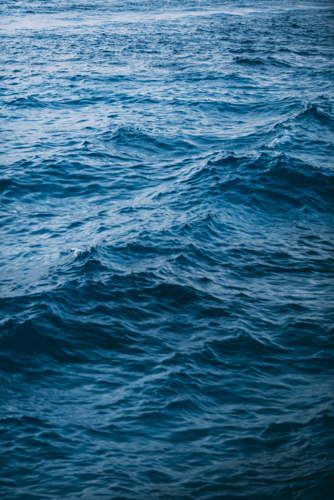

In [54]:
# Resize image and display
thumbnail_size = (500, 500)
img.thumbnail(thumbnail_size)

img

## Implementation

In [55]:
def pixel_sorting(
    image: Image.Image,
    calculate_value: Callable[[np.ndarray], np.ndarray],
    apply_condition: Callable[[np.ndarray], np.ndarray],
    rotation: int = 0,
) -> Image.Image:
    """
    Sorts the pixels in the input image.

    Parameters:
    - image: The input image.
    - calculate_value: A function to calculate values for each pixel.
    - apply_condition: A function to apply a condition to the calculated values.
    - rotation: The rotation angle for the image.

    Returns:
    - An Image with the pixel sorting effect applied.
    """

    def sort_interval(
        interval: np.ndarray,
        interval_indices: np.ndarray,
    ) -> np.ndarray:
        return np.argsort(interval) + interval_indices

    def process_row(
        row: int,
        row_values: np.ndarray,
    ) -> None:
        interval_indices = np.flatnonzero(edges[row])
        split_values = np.split(row_values, interval_indices)

        for index, interval in enumerate(split_values[1:]):
            split_values[index + 1] = sort_interval(interval, interval_indices[index])

        split_values[0] = np.arange(split_values[0].size)

        merged_order = np.concatenate(split_values)

        for channel in range(rotated_pixels.shape[-1]):
            rotated_pixels[row, :, channel] = rotated_pixels[
                row, merged_order.astype("uint32"), channel
            ]

    # Convert the image to a numpy array
    pixel_array = np.array(image)

    # Rotate the pixels based on the specified angle
    rotated_pixels = np.rot90(pixel_array, rotation)

    # Calculate values for each pixel
    pixel_values = calculate_value(rotated_pixels)

    # Compute edges based on the condition
    edges = np.apply_along_axis(
        lambda row: np.convolve(row, [-1, 1], "same"), 0, apply_condition(pixel_values)
    )

    # Process each row
    for row, (row_values, _) in enumerate(zip(pixel_values, edges)):
        process_row(row, row_values)

    # Rotate the pixels back and convert to Image
    return Image.fromarray(np.rot90(rotated_pixels, -rotation))

In [56]:
def apply_condition(lum, threshold=0.5):
    """
    Applies a condition to the luminance values.
    """
    return lum > threshold

### Sorting functions

In [57]:
def hue(pixels):
    """
    Calculates the hue values for each pixel based on the RGB channels.
    """
    r, g, b = np.split(pixels, 3, 2)
    return np.arctan2(np.sqrt(3) * (g - b), 2 * r - g - b)[:, :, 0]

In [58]:
def sat(pixels):
    """
    Calculates the saturation values for each pixel based on the RGB channels.
    """
    r, g, b = np.split(pixels, 3, 2)
    maximum = np.maximum(r, np.maximum(g, b))
    minimum = np.minimum(r, np.minimum(g, b))
    return ((maximum - minimum) / maximum)[:, :, 0]

In [59]:
def laplace(pixels):
    """
    Calculates the Laplacian values for each pixel based on the luminance of the image.
    """
    lum = np.average(pixels, 2) / 255
    return np.abs(
        convolve2d(
            lum,
            np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]),
            "same",
        )
    )

## Applying the pixel sorting effect

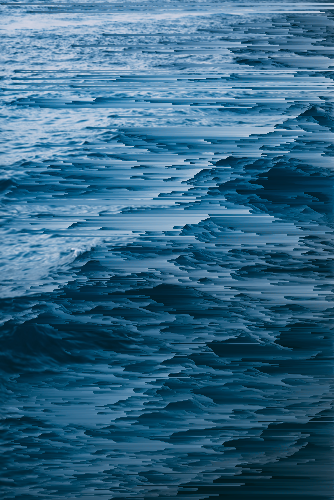

In [60]:
pixel_sorting(
    img,
    lambda pixels: np.average(pixels, axis=2) / 255,
    lambda lum: apply_condition(lum, threshold=0.25) - 90,
)

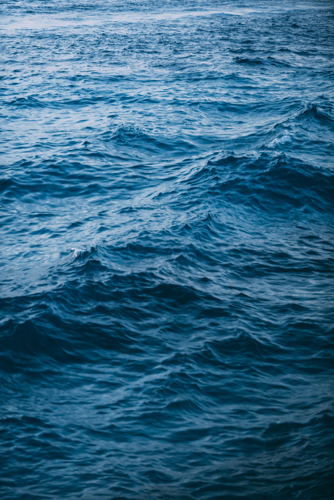

In [61]:
pixel_sorting(
    img,
    hue,
    lambda lum: apply_condition(lum, threshold=0.25),
    -90,
)

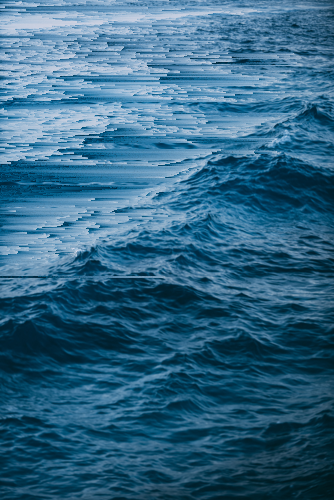

In [62]:
pixel_sorting(
    img,
    sat,
    lambda lum: apply_condition(lum, threshold=0.25),
    -90,
)

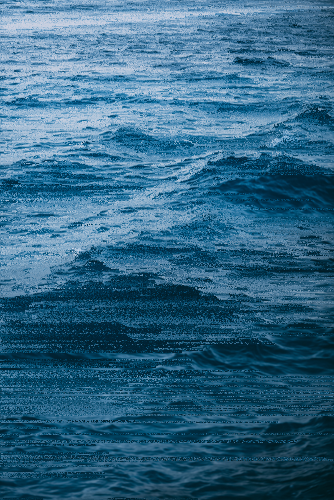

In [63]:
pixel_sorting(
    img,
    laplace,
    lambda lum: apply_condition(lum, threshold=0.25),
    -90,
)

We can also loop over an image applying different effects to improve the final result:

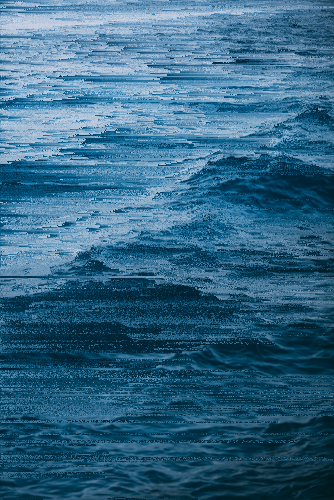

In [64]:
img_copy = img.copy()
effects = [sat, hue, laplace]
for effect in effects:
    img_copy = pixel_sorting(
        img_copy,
        effect,
        lambda lum: apply_condition(lum, threshold=0.25),
        -90,
    )

img_copy

## Final words

Pixel sorting might not be mainstream in generative art, but it's an interesting way to dive into image manipulation and get familiar with tools like NumPy. It adds a creative twist and lets you play with techniques not often seen in the art world. Mixing these skills not only boosts your creative toolbox but also deepens the connection between artistic expression and tech know-how.